In [1]:
import os
import cv2
import numpy as np
from skimage import transform
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

In [2]:
def load_image_and_mask(image_path, mask_path):
    # Загрузка изображения и маски
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

In [3]:
def extract_tail(image, mask):
    # Поиск контуров на маске
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)

    # Получение ограничивающего прямоугольника для контура
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Вырезание хвоста из изображения и маски
    tail = image[y:y+h, x:x+w]
    tail_mask = mask[y:y+h, x:x+w]
    return tail, tail_mask

In [11]:
def normalize_and_align_tail(tail, tail_mask, target_size=(128, 128)):
    # Поиск контуров на маске хвоста. функция возвращает как выровненное изображение хвоста, так и маску хвоста
    contours, _ = cv2.findContours(tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)

    # Определение эллипса, описывающего контур
    (x, y), (MA, ma), angle = cv2.fitEllipse(largest_contour)
    rows, cols, _ = tail.shape

    # Поворот изображения и маски хвоста
    M = cv2.getRotationMatrix2D((x, y), angle, 1)
    rotated_tail = cv2.warpAffine(tail, M, (cols, rows))
    rotated_tail_mask = cv2.warpAffine(tail_mask, M, (cols, rows))

    # Поиск контуров на повернутой маске хвоста
    contours, _ = cv2.findContours(rotated_tail_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None

    # Нахождение самого большого контура
    largest_contour = max(contours, key=cv2.contourArea)

    # Получение ограничивающего прямоугольника для контура
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Вырезание выровненного хвоста из повернутого изображения и маски
    aligned_tail = rotated_tail[y:y+h, x:x+w]
    aligned_tail_mask = rotated_tail_mask[y:y+h, x:x+w]

    # Изменение размера выровненного хвоста и маски до целевого размера
    aligned_tail = cv2.resize(aligned_tail, target_size)
    aligned_tail_mask = cv2.resize(aligned_tail_mask, target_size)
    return aligned_tail, aligned_tail_mask

In [12]:
def calculate_iou(mask1, mask2):
    # Преобразование масок в бинарные массивы. принимает маски одинакового размера
    mask1 = mask1.flatten() > 0
    mask2 = mask2.flatten() > 0

    # Вычисление IoU
    return jaccard_score(mask1, mask2)

In [21]:
def visual(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename):
    # Визуализация изображений и масок
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.contour(mask, colors='green')

    plt.subplot(1, 3, 2)
    plt.title('Aligned Tail')
    plt.imshow(cv2.cvtColor(aligned_tail, cv2.COLOR_BGR2RGB))
    plt.contour(aligned_tail_mask, colors='green')

    plt.subplot(1, 3, 3)
    plt.title('Resized Mask')
    plt.imshow(resized_mask, cmap='gray')

    plt.suptitle(f'Image: {filename}')
    plt.show()

In [22]:
def process_images(image_dir, target_size=(128, 128)):
  # Перед вычислением IoU маска оригинального изображения ресайзится до целевого размера

    iou_scores = []
    for filename in os.listdir(image_dir):
        if filename.startswith('test_image') and filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(image_dir, filename[:-4] + '.png')
            image, mask = load_image_and_mask(image_path, mask_path)
            tail, tail_mask = extract_tail(image, mask)
            if tail is not None and tail_mask is not None:
                aligned_tail, aligned_tail_mask = normalize_and_align_tail(tail, tail_mask, target_size)
                if aligned_tail is not None and aligned_tail_mask is not None:

                    # Изменение размера оригинальной маски до целевого размера
                    resized_mask = cv2.resize(mask, target_size)
                    iou = calculate_iou(resized_mask, aligned_tail_mask)
                    iou_scores.append(iou)
                    print(f'Image: {filename}, IoU: {iou}')

                    # Визуализация изображений и масок
                    visual(image, mask, aligned_tail, aligned_tail_mask, resized_mask, filename)
    return iou_scores

Image: test_image_01.jpg, IoU: 0.54117742987606


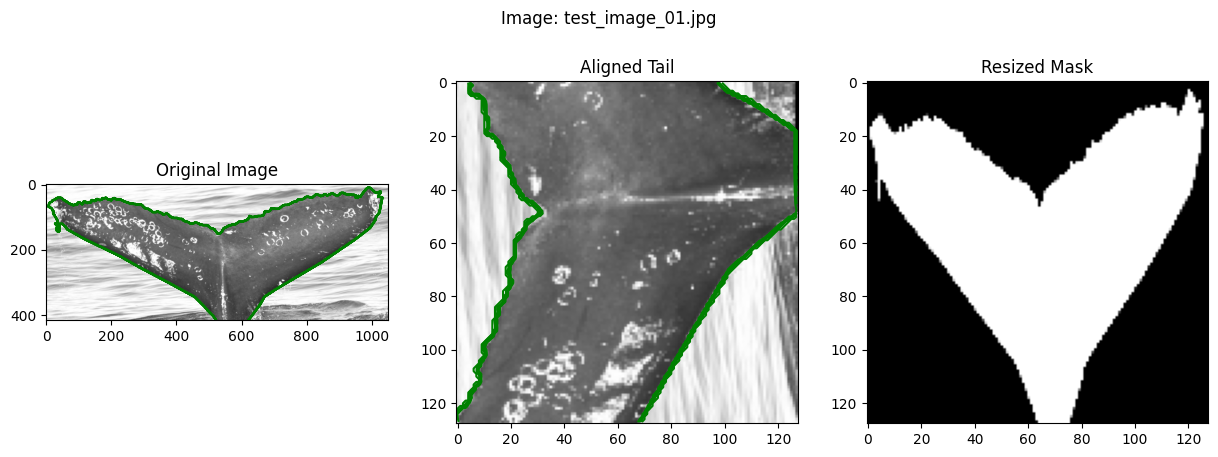

Image: test_image_03.jpg, IoU: 0.17272518558200045


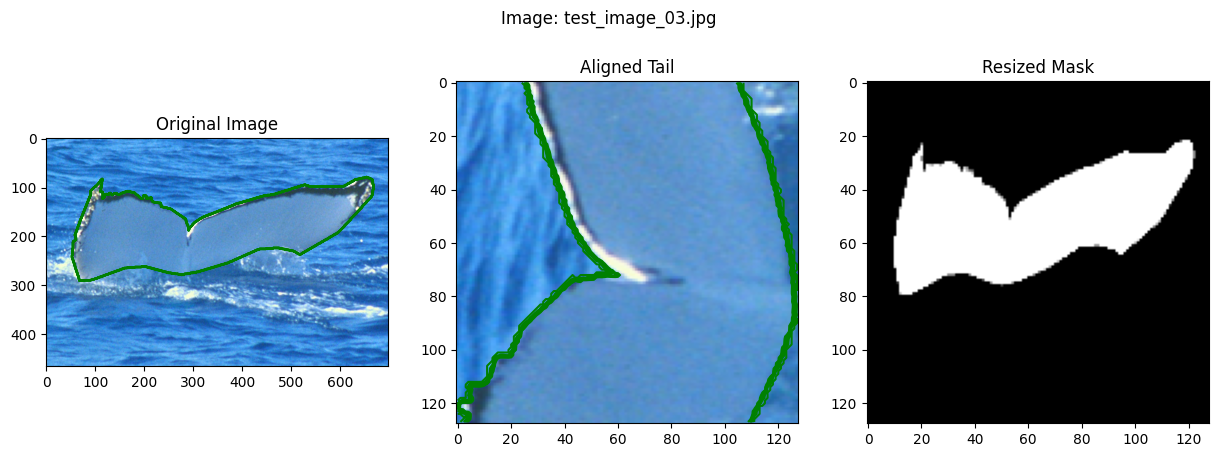

Image: test_image_10.jpg, IoU: 0.34478340940027224


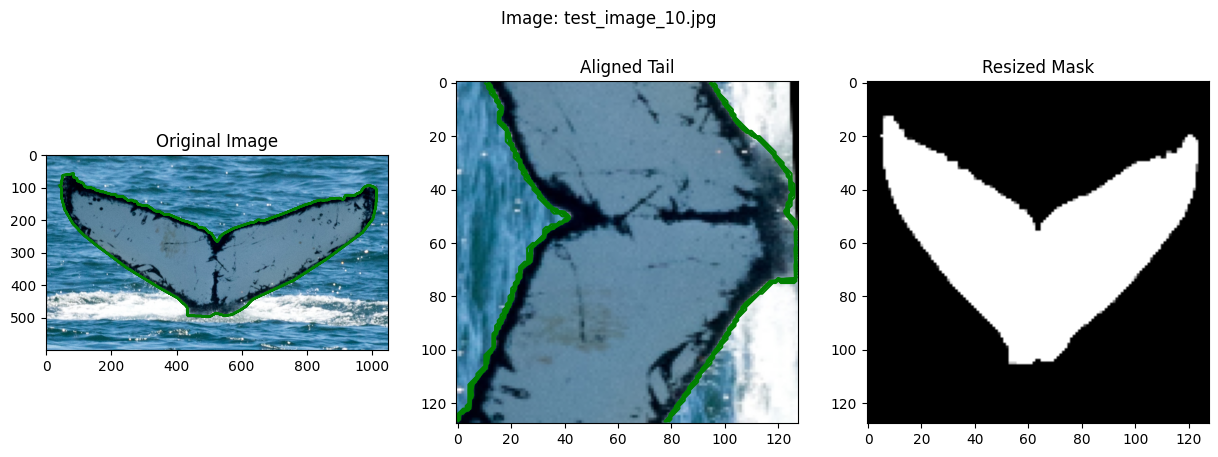

Image: test_image_08.jpg, IoU: 0.1593209780408036


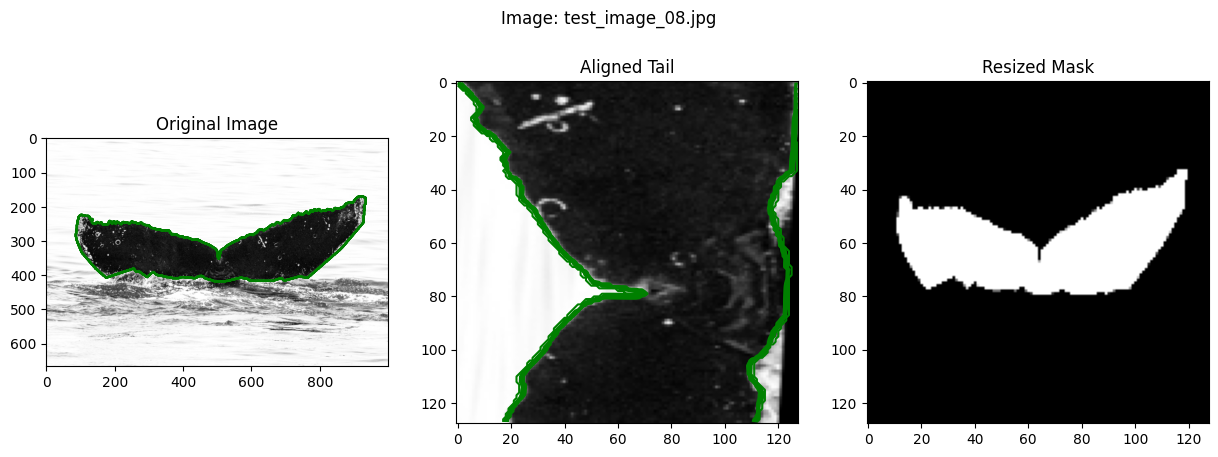

Image: test_image_02.jpg, IoU: 0.2489830378386676


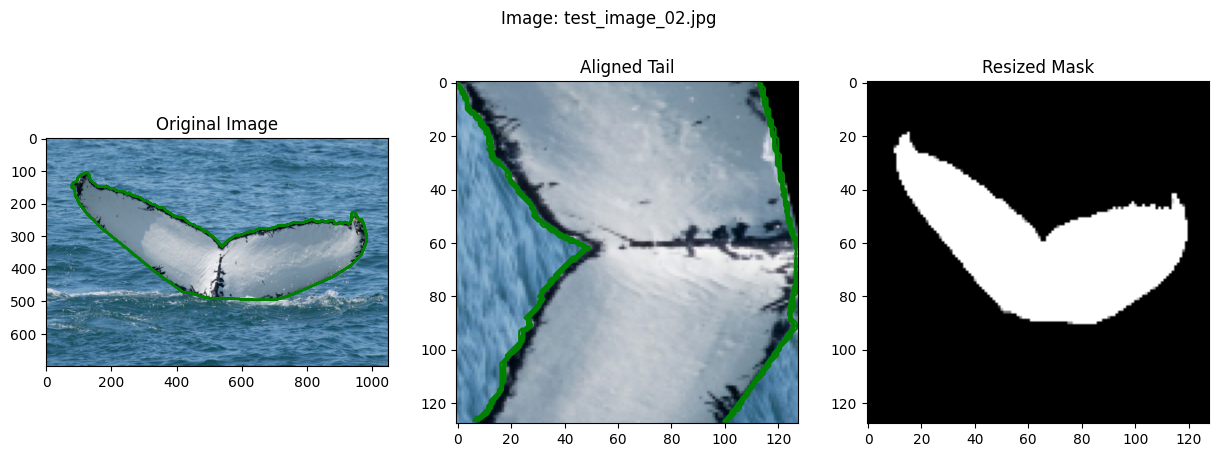

Image: test_image_00.jpg, IoU: 0.4005402971634399


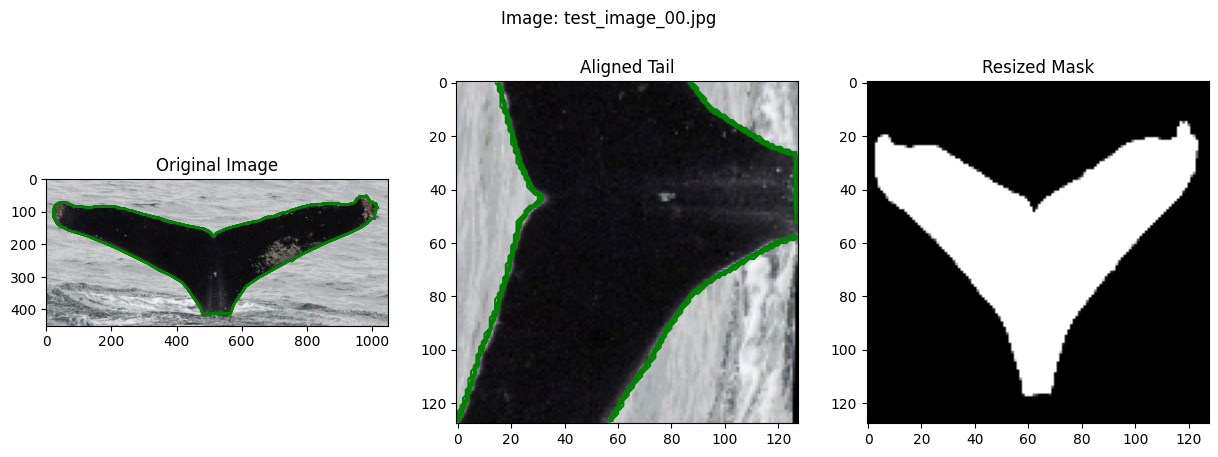

Average IoU: 0.31125505631687395


In [23]:
image_dir = '/content/img/tales'
iou_scores = process_images(image_dir)
print(f'Average IoU: {np.mean(iou_scores)}')